# Detecting levels

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


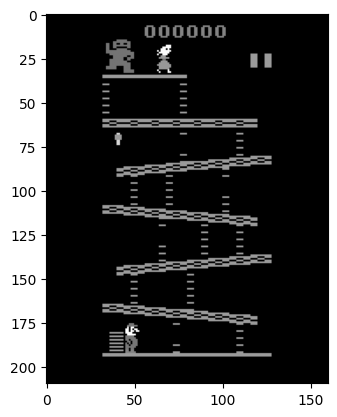

In [1]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
from PIL import Image
import cv2

gym.register_envs(ale_py)

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")

obs, info = env.reset()
gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_obs, cmap="gray")
plt.show()

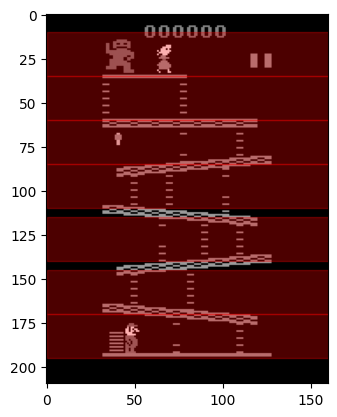

In [33]:
level_height = 25
levels_y_lst = [170, 145, 115, 85, 60, 35, 10]

# plot image with transparent rectangles on each level with different colors
fig, ax = plt.subplots()
for y in levels_y_lst:
	rect = plt.Rectangle((0, y), 256, level_height, color="red", alpha=0.3)
	ax.add_patch(rect)
plt.imshow(gray_obs, cmap="gray")
plt.show()

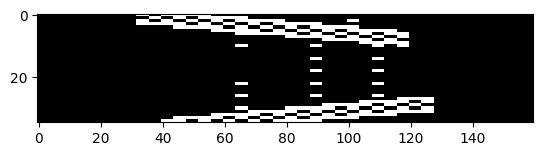

In [99]:
# crop
temp_crop = gray_obs[110:145, :]
plt.imshow(temp_crop, cmap="gray")
plt.show()

# Detecting ladders positions

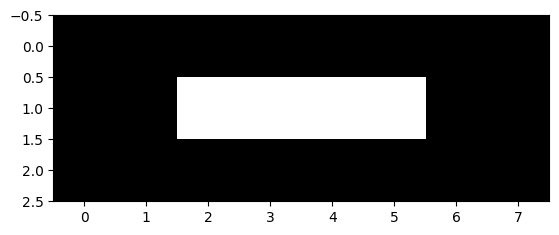

In [125]:
import numpy as np

# ladder part template
# ladder part is 4x1 pixels
w, h = 8, 3
ladder_part = np.zeros((h, w))
ladder_part[1:-1, 2:-2] = 1
plt.imshow(ladder_part, cmap="gray")
plt.show()

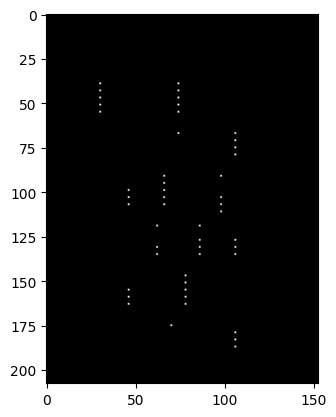

In [126]:
# perform template matching
template_matching_res = cv2.matchTemplate(
	gray_obs.astype(np.float32),
	ladder_part.astype(np.float32),
	cv2.TM_CCOEFF_NORMED
)
# filter
threshold = np.max(template_matching_res)
template_matching_res[template_matching_res < threshold] = 0
plt.imshow(template_matching_res, cmap="gray")
plt.show()

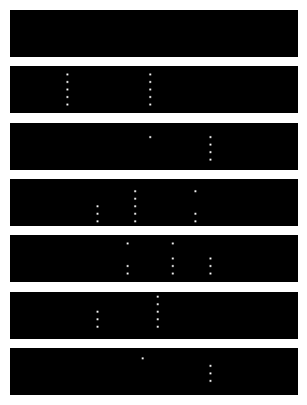

In [42]:
# segment the image into levels
levels_template_matching_res = []
for y in levels_y_lst:
	levels_template_matching_res.append(template_matching_res[y:y+level_height, :])
fig, axs = plt.subplots(len(levels_template_matching_res), 1, figsize=(5, 5))
for i, res in enumerate(levels_template_matching_res[::-1]):
	axs[i].imshow(res, cmap="gray")
	axs[i].axis("off")
plt.show()

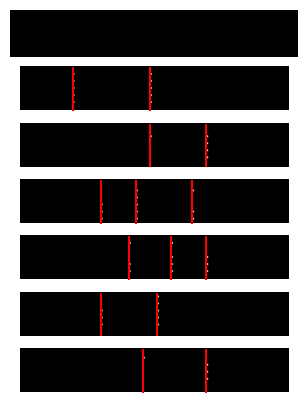

In [80]:
# detect y coordinates that have white pixels
levels_x_coords = []
for i, y in enumerate(levels_y_lst):
	levels_x_coords.append(
		np.unique(np.where(levels_template_matching_res[i] > 0)[1])
	)
fig, axs = plt.subplots(len(levels_x_coords), 1, figsize=(5, 5))
for i, x_coords in enumerate(levels_x_coords[::-1]):
	# draw a vertical line at each x_coords
	axs[i].imshow(levels_template_matching_res[len(levels_template_matching_res)-i-1], cmap="gray")
	axs[i].vlines(x_coords, 0, level_height, color="red")
	axs[i].axis("off")
plt.show()

In [81]:
levels_x_coords

[array([ 70, 106]),
 array([46, 78]),
 array([ 62,  86, 106]),
 array([46, 66, 98]),
 array([ 74, 106]),
 array([30, 74]),
 array([], dtype=int64)]

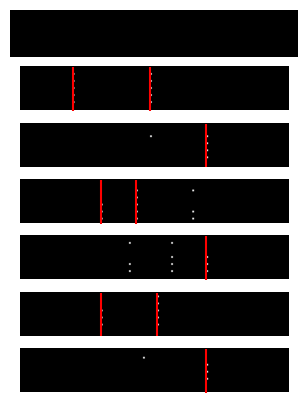

In [90]:
# keep only the ones that their points are all at same distance from each other (use diff)
filtered_levels_x_coords = []
for l, (x_coords, tm_res) in enumerate(zip(levels_x_coords, levels_template_matching_res)):
	filtered_levels_x_coords.append([])
	for x in x_coords:
		x_slice = tm_res[:, x]
		distances = np.diff(np.where(x_slice > 0)[0])
		if len(set(distances)) == 1: # all distances are the same
			filtered_levels_x_coords[l].append(x)

# plot the filtered x_coords
fig, axs = plt.subplots(len(filtered_levels_x_coords), 1, figsize=(5, 5))
for i, x_coords in enumerate(filtered_levels_x_coords[::-1]):
	# draw a vertical line at each x_coords
	axs[i].imshow(levels_template_matching_res[len(levels_template_matching_res)-i-1], cmap="gray")
	axs[i].vlines(x_coords, 0, level_height, color="red")
	axs[i].axis("off")
plt.show()

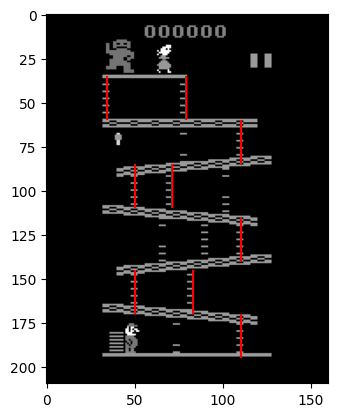

In [97]:
# translate this positions to the original image (gray_obs)
# get the x coordinates of the ladders in the original image
ladders_x_coords = []
for i, x_coords in enumerate(filtered_levels_x_coords[::-1]):
	ladders_x_coords.append(x_coords + np.arange(len(x_coords)))

# sort from bottom to top
ladders_x_coords = ladders_x_coords[::-1]
# correct x coordinates (template matching did top left corner)
ladders_x_coords = [x + ladder_part.shape[1]//2 for x in ladders_x_coords]

# plot the ladders in the original image
fig, ax = plt.subplots()
ax.imshow(gray_obs, cmap="gray")
for i, x_coords in enumerate(ladders_x_coords):
	ax.vlines(x_coords, levels_y_lst[i], levels_y_lst[i]+level_height, color="red")
plt.show()

In [127]:
ladders_x_coords

[array([110]),
 array([50, 83]),
 array([110]),
 array([50, 71]),
 array([110]),
 array([34, 79]),
 array([], dtype=float64)]